In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from numpy import log1p
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv('train.csv')
data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [3]:
data.drop(columns=['id'], inplace=True)


In [4]:
data.isna().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [5]:
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = ['winddirection']

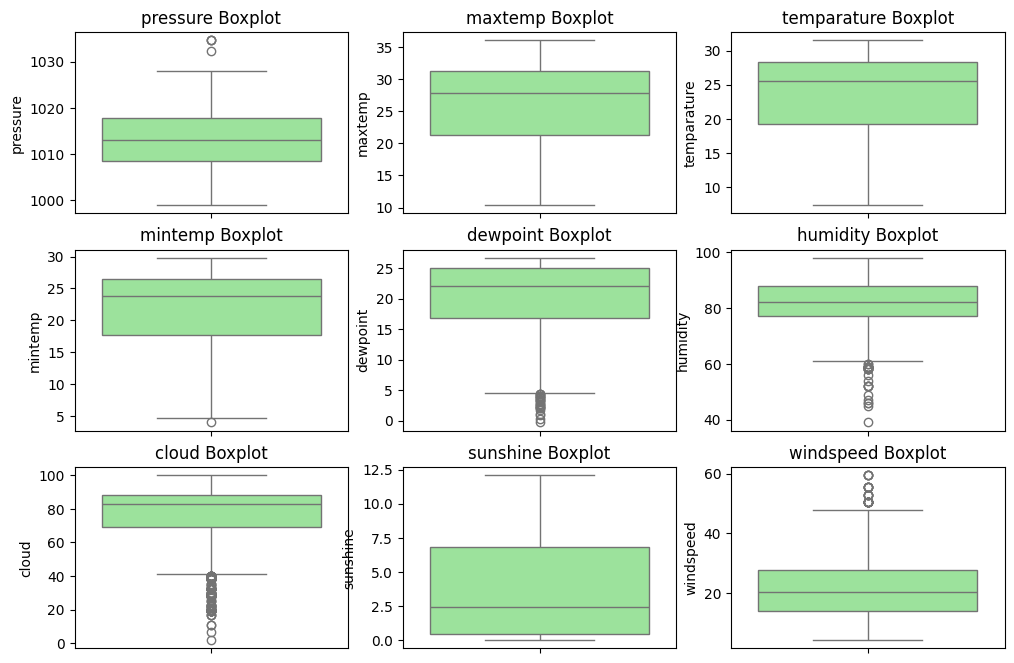

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_variables):
    sns.boxplot(data=data, y=col, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'{col} Boxplot')

In [7]:
def log_data(data):
    for col in numerical_variables:
        data[f"log_{col}"] = np.log1p(data[col])
    return data

In [8]:
data = log_data(data)

In [9]:
data

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,rainfall,log_pressure,log_maxtemp,log_temparature,log_mintemp,log_dewpoint,log_humidity,log_cloud,log_sunshine,log_windspeed
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,1,6.925988,3.100092,3.072693,3.039749,3.015535,4.477337,4.488636,0.741937,2.901422
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,...,1,6.928048,2.844909,2.884801,2.821379,2.797281,4.564348,4.521789,0.000000,3.131137
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,1,6.932545,3.015535,2.839078,2.747271,2.332144,4.330733,3.871201,2.230014,2.949688
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,...,1,6.922053,2.949688,2.933857,2.884801,2.879198,4.564348,4.564348,0.000000,3.600048
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,...,0,6.930299,3.104587,2.965273,2.785011,2.360854,3.970292,3.828641,1.526056,3.250374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,...,1,6.923235,3.186353,3.072693,3.000720,3.039749,4.584967,4.488636,0.095310,3.139833
2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,...,1,6.921066,2.901422,2.906901,2.850707,2.791165,4.521789,4.488636,0.000000,3.591818
2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,...,1,6.921954,2.995732,2.850707,2.727853,2.610070,4.382027,4.382027,1.791759,3.523415
2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,...,1,6.930788,2.856470,2.785011,2.694627,2.753661,4.532599,4.543295,0.095310,2.944439


In [10]:
train=data.drop(target_variable,axis=1)
test=data[target_variable]
x_train,x_test,y_train,y_test=train_test_split(train,test,random_state=42,test_size=.2)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)

In [52]:
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (64, 64, 32)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPRegressor(max_iter=500), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", -grid.best_score_)

Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
Best score: -0.4267416970803922


In [12]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # no 'auto'
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 # Number of parameter settings sampled
    scoring='roc_auc',         # Optimize for ROC AUC
    cv=5,                     # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                 # Use all CPU cores
)

# Run hyperparameter search
random_search.fit(x_train, y_train)

# Best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate on test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(x_test)
y_proba = best_rf.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': np.int64(150), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': np.int64(5), 'bootstrap': True}
              precision    recall  f1-score   support

           0       0.80      0.62      0.70       119
           1       0.87      0.94      0.91       319

    accuracy                           0.86       438
   macro avg       0.84      0.78      0.80       438
weighted avg       0.85      0.86      0.85       438



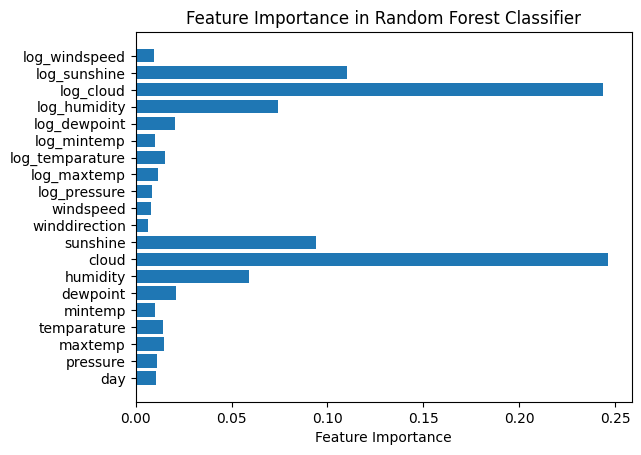

In [56]:
feature_importances = best_rf.feature_importances_

plt.barh(x_train.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],  # 'elasticnet' or 'none' if solver supports
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],  # use saga for large/elasticnet
    'max_iter': [100, 200, 500]
}
logreg = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',  # or 'roc_auc', 'f1' for imbalanced data
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8721497761497762


In [13]:
test_data = pd.read_csv('test.csv')
test_final = test_data.drop(columns=['id'])

In [14]:
test_final = log_data(test_final)

In [15]:
test_final

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,log_pressure,log_maxtemp,log_temparature,log_mintemp,log_dewpoint,log_humidity,log_cloud,log_sunshine,log_windspeed
0,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3,6.928048,2.917771,2.821379,2.617396,2.766319,4.574711,4.605170,0.000000,3.230804
1,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3,6.925104,2.917771,2.862201,2.821379,2.778819,4.584967,4.605170,0.000000,3.591818
2,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9,6.932350,2.501436,2.433613,2.341806,2.292535,4.465908,4.574711,0.000000,2.884801
3,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6,6.931374,3.072693,2.906901,2.785011,2.351375,4.330733,3.828641,2.091864,3.943522
4,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4,6.930690,2.839078,2.694627,2.001480,1.667707,4.234107,3.912023,2.322388,3.015535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,6.929321,2.954910,2.923162,2.839078,2.687847,4.574711,4.564348,0.000000,3.563883
726,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,6.920375,3.186353,2.949688,2.833213,2.833213,4.369448,4.394449,0.955511,3.265759
727,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,6.931179,3.091042,2.970414,2.890372,2.803360,4.532599,4.574711,0.000000,3.131137
728,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5,6.923038,3.091042,3.044522,3.030134,3.034953,4.553877,4.543295,0.000000,3.701302


In [16]:
y_pred = best_rf.predict(test_final)
submission = pd.DataFrame({'id': test_data['id'], 'rainfall': y_pred})
submission.to_csv('submission.csv', index=False)